In [1]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn as dglnn
from dgl import AddSelfLoop
from dgl.data import CoraGraphDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl import DGLGraph


In [36]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata["h"] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 16)
        self.layer2 = GCNLayer(16, 7)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

    

def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")


net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [37]:
dataset = CoraGraphDataset()

import pandas as pd

g = dataset[0]
feats = g.ndata['feat']
labels = g.ndata['label']
data = pd.DataFrame({'feats': torch.tensor(range(2708)), 'labels': labels})

aflite_data = pd.read_csv("aflite.csv")
aflite_data.head()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


,Unnamed: 0,feats,labels
0,0,1,4
1,1,2,4
2,2,3,0
3,3,4,3
4,4,5,2


In [38]:
removed_nodes = torch.tensor(list(set(range(len(data))) - set(aflite_data['feats'].values)))

In [39]:
g.remove_nodes(removed_nodes)

features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
val_mask = g.ndata["val_mask"]
sum(train_mask), sum(val_mask), sum(test_mask)

(tensor(103), tensor(364), tensor(736))

In [40]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [41]:
import time

import numpy as np

# Add edges between each node and itself to preserve old node representations



dur = []
seeds = [10,20,30,40]
epochs = 50
val_acc = np.zeros((len(seeds), epochs))
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
nets = []

for i_s, seed in enumerate(seeds):
    set_seed(seed)
    
    dataset = CoraGraphDataset()
    g = dataset[0]
    g.remove_nodes(removed_nodes)
    g.add_edges(g.nodes(), g.nodes())
    
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    net = Net()
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

    for epoch in range(epochs):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)

        acc = evaluate(net, g, features, labels, val_mask)
        val_acc = evaluate(net, g, features, labels, test_mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, np.mean(dur)
            )
        )
        test_acc[i_s][epoch] = acc
        val_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9830 | Test Acc 0.2143 | Time(s) nan
Epoch 00001 | Loss 1.9067 | Test Acc 0.2253 | Time(s) nan
Epoch 00002 | Loss 1.8335 | Test Acc 0.2143 | Time(s) nan
Epoch 00003 | Loss 1.7572 | Test Acc 0.2143 | Time(s) 0.0146
Epoch 00004 | Loss 1.6872 | Test Acc 0.2198 | Time(s) 0.0141
Epoch 00005 | Loss 1.6206 | Test Acc 0.2308 | Time(s) 0.0141
Epoch 00006 | Loss 1.5562 | Test Acc 0.2527 | Time(s) 0.0146


/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00007 | Loss 1.4937 | Test Acc 0.2720 | Time(s) 0.0161
Epoch 00008 | Loss 1.4318 | Test Acc 0.2830 | Time(s) 0.0160
Epoch 00009 | Loss 1.3701 | Test Acc 0.2967 | Time(s) 0.0154
Epoch 00010 | Loss 1.3100 | Test Acc 0.3132 | Time(s) 0.0150
Epoch 00011 | Loss 1.2530 | Test Acc 0.3269 | Time(s) 0.0151
Epoch 00012 | Loss 1.1988 | Test Acc 0.3599 | Time(s) 0.0153
Epoch 00013 | Loss 1.1461 | Test Acc 0.4011 | Time(s) 0.0153
Epoch 00014 | Loss 1.0958 | Test Acc 0.4560 | Time(s) 0.0152
Epoch 00015 | Loss 1.0487 | Test Acc 0.4725 | Time(s) 0.0151
Epoch 00016 | Loss 1.0045 | Test Acc 0.4753 | Time(s) 0.0153
Epoch 00017 | Loss 0.9608 | Test Acc 0.4863 | Time(s) 0.0152
Epoch 00018 | Loss 0.9167 | Test Acc 0.4945 | Time(s) 0.0156
Epoch 00019 | Loss 0.8741 | Test Acc 0.4973 | Time(s) 0.0155
Epoch 00020 | Loss 0.8332 | Test Acc 0.5082 | Time(s) 0.0155
Epoch 00021 | Loss 0.7936 | Test Acc 0.5247 | Time(s) 0.0153
Epoch 00022 | Loss 0.7549 | Test Acc 0.5247 | Time(s) 0.0151
Epoch 00023 | Loss 0.717

Epoch 00039 | Loss 0.1379 | Test Acc 0.6346 | Time(s) 0.0164
Epoch 00040 | Loss 0.1317 | Test Acc 0.6346 | Time(s) 0.0164
Epoch 00041 | Loss 0.1260 | Test Acc 0.6374 | Time(s) 0.0164
Epoch 00042 | Loss 0.1208 | Test Acc 0.6346 | Time(s) 0.0164
Epoch 00043 | Loss 0.1159 | Test Acc 0.6319 | Time(s) 0.0164
Epoch 00044 | Loss 0.1114 | Test Acc 0.6264 | Time(s) 0.0164
Epoch 00045 | Loss 0.1071 | Test Acc 0.6209 | Time(s) 0.0164
Epoch 00046 | Loss 0.1032 | Test Acc 0.6236 | Time(s) 0.0165
Epoch 00047 | Loss 0.0995 | Test Acc 0.6209 | Time(s) 0.0165
Epoch 00048 | Loss 0.0960 | Test Acc 0.6236 | Time(s) 0.0165
Epoch 00049 | Loss 0.0926 | Test Acc 0.6236 | Time(s) 0.0165
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9331 | Test Acc 0.1401 | Time(s) 0.0165
Epoch 00001 | Loss 1.8366 | Test Acc 0.1951 | Time(s) 0.0165
Epoch 00002 | Loss 1.7376

In [42]:
accs = []
for i, net in enumerate(nets):
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask']))
print(f"{np.mean(accs)} (+/-{np.std(accs)})")

0.6012228260869565 (+/-0.013467545924999335)


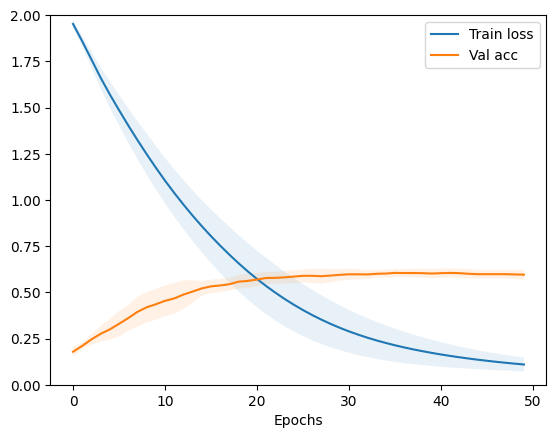

In [43]:
# import matplotlib.pyplot as plt

# plt.plot(test_acc)
# plt.plot(train_loss)
# plt.show

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.ylim(0, 2)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()

In [44]:
dataset = CoraGraphDataset()
g = dataset[0]
features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
val_mask = g.ndata["val_mask"]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [45]:
sum(train_mask), sum(test_mask)

(tensor(140), tensor(1000))

In [46]:
import time

import numpy as np

net = Net()

# Add edges between each node and itself to preserve old node representations
g.add_edges(g.nodes(), g.nodes())

optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []
test_acc = []
train_loss = []


dur = []
seeds = [10,20,30,40]
epochs = 50
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
nets = []



for i_s, seed in enumerate(seeds):
    set_seed(seed)
    
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    
    net = Net()
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
    for epoch in range(epochs):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)

        acc = evaluate(net, g, features, labels, val_mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, np.mean(dur)
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9604 | Test Acc 0.2420 | Time(s) nan
Epoch 00001 | Loss 1.8236 | Test Acc 0.2900 | Time(s) nan
Epoch 00002 | Loss 1.6995 | Test Acc 0.3360 | Time(s) nan
Epoch 00003 | Loss 1.6087 | Test Acc 0.4100 | Time(s) 0.0166
Epoch 00004 | Loss 1.5259 | Test Acc 0.5080 | Time(s) 0.0167
Epoch 00005 | Loss 1.4454 | Test Acc 0.5460 | Time(s) 0.0184
Epoch 00006 | Loss 1.3672 | Test Acc 0.5880 | Time(s) 0.0184
Epoch 00007 | Loss 1.2928 | Test Acc 0.6120 | Time(s) 0.0183
Epoch 00008 | Loss 1.2198 | Test Acc 0.6340 | Time(s) 0.0195
Epoch 00009 | Loss 1.1474 | Test Acc 0.6340 | Time(s) 0.0194
Epoch 00010 | Loss 1.0765 | Test Acc 0.6460 | Time(s) 0.0199
Epoch 00011 | Loss 1.0081 | Test Acc 0.6540 | Time(s) 0.0199
Epoch 00012 | Loss 0.9429 | Test Acc 0.6760 | Time(s) 0.0198
Epoch 00013 | Loss 0.8813 | Test A

Epoch 00031 | Loss 0.2863 | Test Acc 0.7240 | Time(s) 0.0227
Epoch 00032 | Loss 0.2706 | Test Acc 0.7240 | Time(s) 0.0227
Epoch 00033 | Loss 0.2557 | Test Acc 0.7280 | Time(s) 0.0228
Epoch 00034 | Loss 0.2418 | Test Acc 0.7280 | Time(s) 0.0227
Epoch 00035 | Loss 0.2286 | Test Acc 0.7280 | Time(s) 0.0227
Epoch 00036 | Loss 0.2162 | Test Acc 0.7280 | Time(s) 0.0227
Epoch 00037 | Loss 0.2046 | Test Acc 0.7300 | Time(s) 0.0227
Epoch 00038 | Loss 0.1937 | Test Acc 0.7300 | Time(s) 0.0227
Epoch 00039 | Loss 0.1835 | Test Acc 0.7320 | Time(s) 0.0227
Epoch 00040 | Loss 0.1739 | Test Acc 0.7300 | Time(s) 0.0227
Epoch 00041 | Loss 0.1650 | Test Acc 0.7260 | Time(s) 0.0227
Epoch 00042 | Loss 0.1568 | Test Acc 0.7260 | Time(s) 0.0226
Epoch 00043 | Loss 0.1490 | Test Acc 0.7280 | Time(s) 0.0226
Epoch 00044 | Loss 0.1418 | Test Acc 0.7280 | Time(s) 0.0226
Epoch 00045 | Loss 0.1350 | Test Acc 0.7280 | Time(s) 0.0226
Epoch 00046 | Loss 0.1286 | Test Acc 0.7260 | Time(s) 0.0225
Epoch 00047 | Loss 0.122

In [47]:
accs = []
for i, net in enumerate(nets):
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask']))
print(f"{np.mean(accs)} (+/-{np.std(accs)})")

0.7240000000000001 (+/-0.008860022573334682)


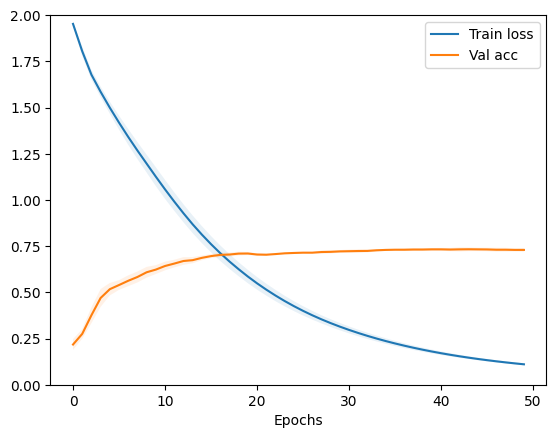

In [48]:
# import matplotlib.pyplot as plt

# plt.plot(test_acc)
# plt.plot(train_loss)
# plt.show

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.ylim(0, 2)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()

In [49]:
import time

import numpy as np

net = Net()

# Add edges between each node and itself to preserve old node representations

optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []
test_acc = []
train_loss = []


dur = []
seeds = [10,20,30,40]
epochs = 50
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
nets = []



for i_s, seed in enumerate(seeds):
    set_seed(seed)
    random_ids = np.random.choice(range(len(data)), len(data) - len(aflite_data), replace=False)
    dataset = CoraGraphDataset()
    g = dataset[0]
    
    g.remove_nodes(random_ids)
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    g.add_edges(g.nodes(), g.nodes())

    net = Net()
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
    for epoch in range(epochs):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)

        acc = evaluate(net, g, features, labels, val_mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, np.mean(dur)
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9710 | Test Acc 0.2137 | Time(s) nan
Epoch 00001 | Loss 1.9007 | Test Acc 0.2466 | Time(s) nan
Epoch 00002 | Loss 1.8289 | Test Acc 0.2493 | Time(s) nan
Epoch 00003 | Loss 1.7400 | Test Acc 0.3726 | Time(s) 0.0154
Epoch 00004 | Loss 1.6462 | Test Acc 0.4301 | Time(s) 0.0146
Epoch 00005 | Loss 1.5511 | Test Acc 0.4603 | Time(s) 0.0147
Epoch 00006 | Loss 1.4561 | Test Acc 0.5151 | Time(s) 0.0144
Epoch 00007 | Loss 1.3624 | Test Acc 0.5507 | Time(s) 0.0142
Epoch 00008 | Loss 1.2700 | Test Acc 0.5699 | Time(s) 0.0146
Epoch 00009 | Loss 1.1806 | Test Acc 0.6110 | Time(s) 0.0144
Epoch 00010 | Loss 1.0951 | Test Acc 0.6301 | Time(s) 0.0146
Epoch 00011 | Loss 1.0140 | Test Acc 0.6466 | Time(s) 0.0145
Epoch 00012 | Loss 0.9373 | Test Acc 0.6712 | Time(s) 0.0158
Epoch 00013 | Loss 0.8657 | Test A

Epoch 00028 | Loss 0.3209 | Test Acc 0.6953 | Time(s) 0.0154
Epoch 00029 | Loss 0.3034 | Test Acc 0.7008 | Time(s) 0.0154
Epoch 00030 | Loss 0.2870 | Test Acc 0.7064 | Time(s) 0.0154
Epoch 00031 | Loss 0.2719 | Test Acc 0.7091 | Time(s) 0.0154
Epoch 00032 | Loss 0.2581 | Test Acc 0.7119 | Time(s) 0.0154
Epoch 00033 | Loss 0.2452 | Test Acc 0.7147 | Time(s) 0.0155
Epoch 00034 | Loss 0.2333 | Test Acc 0.7202 | Time(s) 0.0155
Epoch 00035 | Loss 0.2223 | Test Acc 0.7341 | Time(s) 0.0155
Epoch 00036 | Loss 0.2122 | Test Acc 0.7285 | Time(s) 0.0155
Epoch 00037 | Loss 0.2029 | Test Acc 0.7341 | Time(s) 0.0155
Epoch 00038 | Loss 0.1944 | Test Acc 0.7396 | Time(s) 0.0155
Epoch 00039 | Loss 0.1864 | Test Acc 0.7424 | Time(s) 0.0155
Epoch 00040 | Loss 0.1790 | Test Acc 0.7396 | Time(s) 0.0155
Epoch 00041 | Loss 0.1721 | Test Acc 0.7396 | Time(s) 0.0154
Epoch 00042 | Loss 0.1658 | Test Acc 0.7424 | Time(s) 0.0154
Epoch 00043 | Loss 0.1598 | Test Acc 0.7285 | Time(s) 0.0154
Epoch 00044 | Loss 0.154

In [50]:
accs = []
for i, net in enumerate(nets):
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask']))
print(f"{np.mean(accs)} (+/-{np.std(accs)})")

0.6986301369863014 (+/-0.0372139115265921)


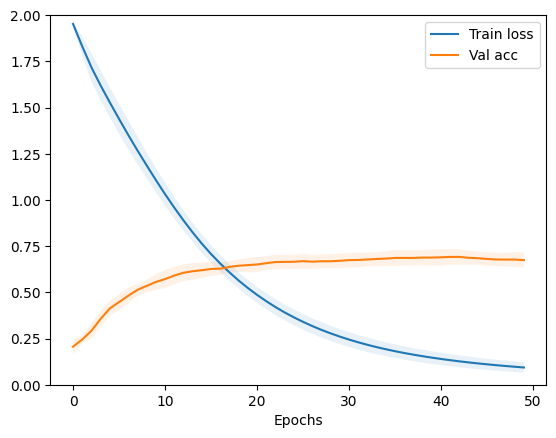

In [51]:
# import matplotlib.pyplot as plt

# plt.plot(test_acc)
# plt.plot(train_loss)
# plt.show

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.ylim(0, 2)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()